# Effect of instantaneous weather sampling rate on subhourly clipping errors - SURFRAD-tbl
These notebooks resample the SURFRAD network data at different frequencies to simulate satellite data.

In [1]:
import calendar
from dataclasses import dataclass
import pathlib
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import pvlib
import rdtools
import seaborn as sns
from tqdm import tqdm

In [2]:
sns.set(font_scale=1.5, rc={'figure.figsize': (12, 8)})

In [3]:
# CONSTANTS
# https://gml.noaa.gov/grad/surfrad/sitepage.html
SURFRAD_TZ = {
    'bon': '-06:00', 'tbl': '-07:00', 'dra': '-08:00', 'fpk': '-07:00',
    'gwn': '-06:00', 'psu': '-05:00', 'sxf': '-06:00'}

## Some useful functions
* `read_surfrad_year` just reads all daily files from a yearly surfrad folder

In [4]:
def read_surfrad_year(surfrad_year_path):
    """
    Parameters
    -----------
    surfrad_year_path : pathlib.Path
        path to folder containing a single year of daily SURFRAD data files
    Returns
    -------
    df : pandas.DataFrame
        All of the daily weather data from folder of single year concatentated
        along time axis
    header : dict
        info about the location, timezone, and station name
    """
    data = [pvlib.iotools.read_surfrad(f) for f in surfrad_year_path.iterdir()]
    dfs, heads = zip(*data)
    df = pd.concat(dfs)
    header = heads[0]
    return df, header

## Accessing SURFRAD data
SURFRAD has 7 stations. pvlib-python has functions to download data from SURFRAD, but it takes a while, so I have previously downloaded and cached the data in folders for each station. Inside each station folder, there are folders for each year with data. Most stations began measurements in 1995 and continuously add new data one day at a time. These daily data files are stored in the yearly folders.

Here I specify the path the SURFRAD folder that contains all of the stations and then pick a single station to look at in this folder. Later we can try to manipulate all of the stations after working out the algorithms.

In [5]:
# specify path to all SURFRAD station data
surfrad_dir = pathlib.Path('../../SURFRAD')
print(f'Is there really a \33[1m\33[91m"SURFRAD"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{surfrad_dir.exists()} \u2713\33[0m\33[0m')

Is there really a "SURFRAD" directory? True ✓


In [6]:
# specify path to just a single station, EG: Bondville, IL
weather_dir = "Boulder_CO"
weather_path = surfrad_dir / weather_dir
print(f'Is there really a \33[1m\33[91m"{weather_path}"\33[0m\33[0m directory?'
      f' \33[1m\33[92m{weather_path.exists()} \u2713\33[0m\33[0m')

Is there really a "..\..\SURFRAD\Boulder_CO" directory? True ✓


In [7]:
# display what years are in the SURFRAD station folder
weather_year_paths = weather_path.iterdir()
years = [p.parts[-1] for p in weather_year_paths]
', '.join(years)

'1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021'

## Narrowing Selection
There are a lot of years in a single station because SURFRAD has been operating for over 25 years! We can narrow our selection and make our work easier by checking:
* timestep or time-interval
* completeness of the year
* containing all of the required data

### Timesteps
SURFRAD stations collect data at either 3-minute or 1-minute intervals. For example, up until 2009, the Bondville, IL, station collected data at 3-minute intervals and then afterwards colected at 1-minute intervals. I narrow the selection by only using 1-minute intervals.

### Yearly Completeness
Each year has missing data, so I further narrow the selection by only using years that are at least 98% complete.

### Data Fields
Some of the fields are also missing. For example 1995 is missing all of the diffuse horizontal irradiance and about half of the air temperature data. I further narrow the selection by only using years with GHI, DHI, DNI, air temperature, wind speed, and solar zenith. This is a complete data set.

In [8]:
# how many years are missing data?
REQD_COLS = ['ghi', 'dhi', 'dni', 'solar_zenith', 'wind_speed', 'temp_air', 'pressure', 'relative_humidity']
weather_years = dict.fromkeys(years)
weather_stats = pd.DataFrame(index=years, columns=['Number of Records', 'Expected', 'Timestep', 'Completeness'])
for weather_year in tqdm(weather_path.iterdir()):
    weather_df, weather_header = read_surfrad_year(weather_year)
    year = weather_year.parts[-1]
    dt = np.diff(weather_df.index).min().seconds/60
    weather_years[year] = weather_df[REQD_COLS].dropna()
    num_recs = weather_years[year].shape[0]
    daze = 365*24*60/dt
    if calendar.isleap(int(year)):
        daze += (24*60/dt)
    frac_recs = num_recs/daze
    weather_stats.loc[year] = (num_recs, daze, dt, frac_recs)
weather_stats

27it [06:43, 14.96s/it]


,Number of Records,Expected,Timestep,Completeness
1995,12960,175200.0,3.0,0.073973
1996,149942,175680.0,3.0,0.853495
1997,166808,175200.0,3.0,0.9521
1998,171881,175200.0,3.0,0.981056
1999,174786,175200.0,3.0,0.997637
2000,174179,175680.0,3.0,0.991456
2001,173476,175200.0,3.0,0.99016
2002,173461,175200.0,3.0,0.990074
2003,173206,175200.0,3.0,0.988619
2004,173888,175680.0,3.0,0.9898


In [9]:
weather_header

{'name': 'Table Mountain',
 'latitude': 40.125,
 'longitude': -105.237,
 'elevation': 1689.0,
 'surfrad_version': 1,
 'tz': 'UTC'}

In [10]:
weather_df.columns

Index(['year', 'jday', 'month', 'day', 'hour', 'minute', 'dt', 'solar_zenith',
       'ghi', 'ghi_flag', 'uw_solar', 'uw_solar_flag', 'dni', 'dni_flag',
       'dhi', 'dhi_flag', 'dw_ir', 'dw_ir_flag', 'dw_casetemp',
       'dw_casetemp_flag', 'dw_dometemp', 'dw_dometemp_flag', 'uw_ir',
       'uw_ir_flag', 'uw_casetemp', 'uw_casetemp_flag', 'uw_dometemp',
       'uw_dometemp_flag', 'uvb', 'uvb_flag', 'par', 'par_flag', 'netsolar',
       'netsolar_flag', 'netir', 'netir_flag', 'totalnet', 'totalnet_flag',
       'temp_air', 'temp_air_flag', 'relative_humidity',
       'relative_humidity_flag', 'wind_speed', 'wind_speed_flag',
       'wind_direction', 'wind_direction_flag', 'pressure', 'pressure_flag'],
      dtype='object')

## QA/QC
Selecting only years that are > 98% complete and have 1-minute timestep, we reduce the number of years to 8: from 2010-2015, 2017, 2019

In [11]:
is_dt_1min = (weather_stats['Timestep'].values.astype(int) == 1)
is_98pct_complete = (weather_stats['Completeness'].values >= 0.98)
selected_years = weather_stats[is_dt_1min & is_98pct_complete]
selected_years

,Number of Records,Expected,Timestep,Completeness
2010,519621,525600.0,1.0,0.988624
2012,523840,527040.0,1.0,0.993928
2013,518807,525600.0,1.0,0.987076
2014,521608,525600.0,1.0,0.992405
2016,517222,527040.0,1.0,0.981371
2018,519268,525600.0,1.0,0.987953
2020,517675,527040.0,1.0,0.982231


In [12]:
# pop the unselected years from weather_years
for year in years:
    if year not in selected_years.index:
        print(f'{year}: {weather_stats.loc[year, "Completeness"]} complete and {weather_stats.loc[year, "Timestep"]}-min timestep')
        weather_years.pop(year)
list(weather_years.keys())

1995: 0.07397260273972603 complete and 3.0-min timestep
1996: 0.8534949908925319 complete and 3.0-min timestep
1997: 0.9521004566210046 complete and 3.0-min timestep
1998: 0.9810559360730594 complete and 3.0-min timestep
1999: 0.9976369863013699 complete and 3.0-min timestep
2000: 0.9914560564663024 complete and 3.0-min timestep
2001: 0.9901598173515982 complete and 3.0-min timestep
2002: 0.990074200913242 complete and 3.0-min timestep
2003: 0.9886187214611872 complete and 3.0-min timestep
2004: 0.989799635701275 complete and 3.0-min timestep
2005: 0.9886986301369863 complete and 3.0-min timestep
2006: 0.979337899543379 complete and 3.0-min timestep
2007: 0.9950684931506849 complete and 3.0-min timestep
2008: 0.9829633424408014 complete and 3.0-min timestep
2009: 0.9647907153729072 complete and 1.0-min timestep
2011: 0.9795928462709285 complete and 1.0-min timestep
2015: 0.9795300608828006 complete and 1.0-min timestep
2017: 0.9708390410958904 complete and 1.0-min timestep
2019: 0.9151

['2010', '2012', '2013', '2014', '2016', '2018', '2020']

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:20<00:00,  2.91s/it]


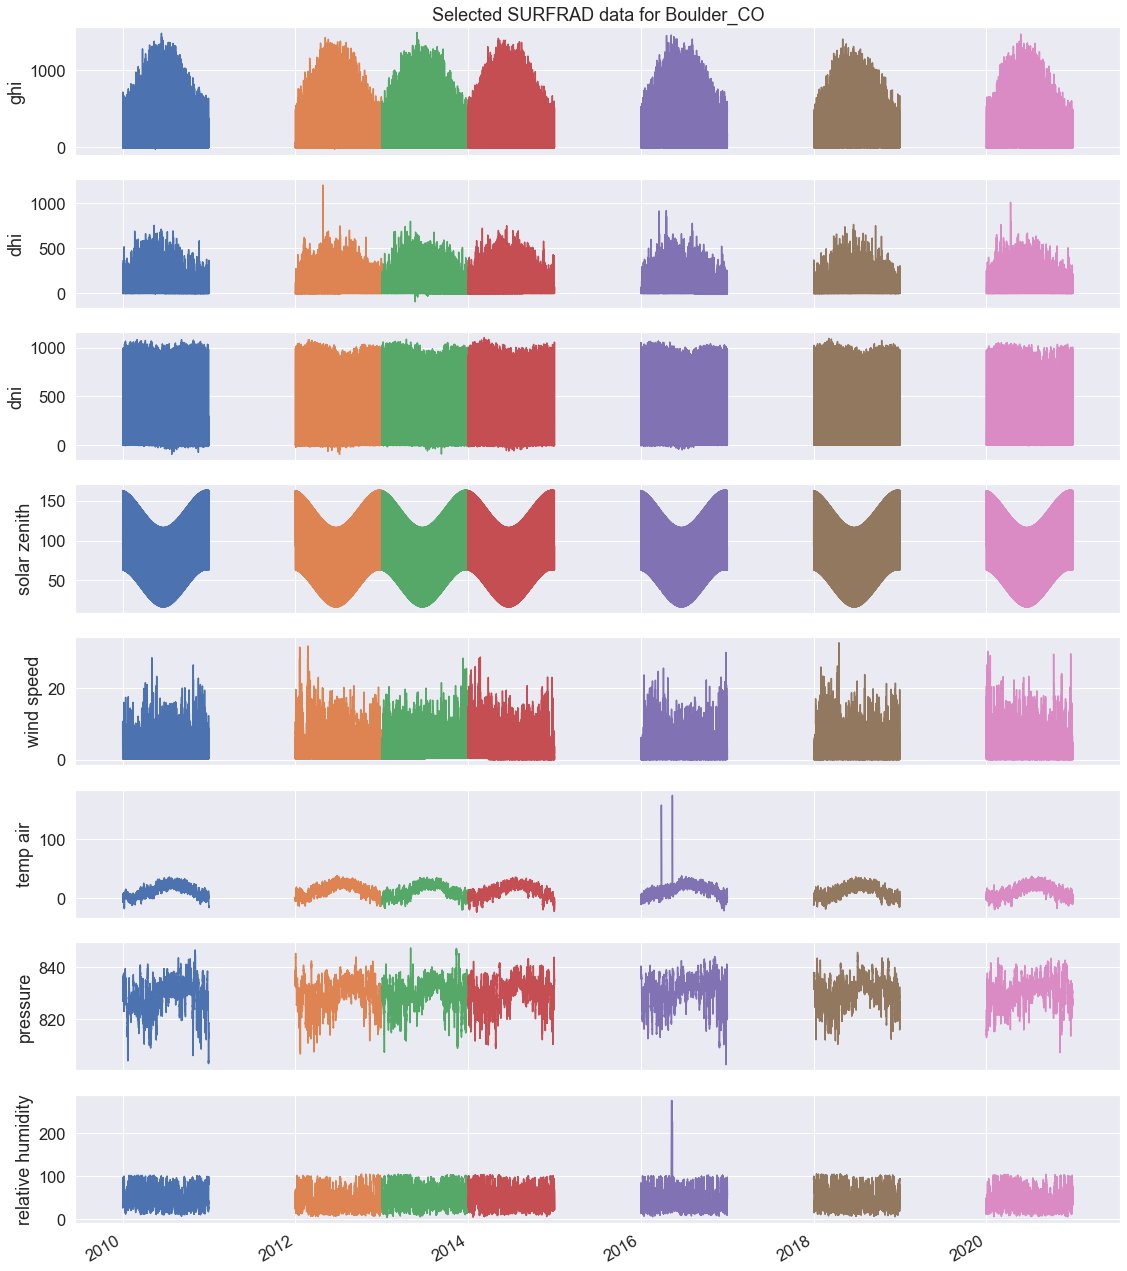

In [13]:
f, ax = plt.subplots(len(REQD_COLS), 1, sharex=True, figsize=(16, 18))
for n, k in enumerate(REQD_COLS):
    for year in tqdm(selected_years.index):
        #print(f'making plot of {k} for {year}')
        weather_years[year][k].plot(ax=ax[n])
    ax[n].set_ylabel(k.replace('_', ' '))
ax[0].set_title(f'Selected SURFRAD data for {weather_dir}')
f.tight_layout()

In [14]:
LATITUDE = weather_header['latitude']
LONGITUDE = weather_header['longitude']
ELEVATION = weather_header['elevation']
YEAR = selected_years.index[0]
print(f'year: {YEAR}')
TIMES = weather_years[YEAR].index

year: 2010


In [15]:
TIMES

DatetimeIndex(['2010-01-01 00:00:00+00:00', '2010-01-01 00:01:00+00:00',
               '2010-01-01 00:02:00+00:00', '2010-01-01 00:03:00+00:00',
               '2010-01-01 00:04:00+00:00', '2010-01-01 00:05:00+00:00',
               '2010-01-01 00:06:00+00:00', '2010-01-01 00:07:00+00:00',
               '2010-01-01 00:08:00+00:00', '2010-01-01 00:09:00+00:00',
               ...
               '2010-12-31 23:50:00+00:00', '2010-12-31 23:51:00+00:00',
               '2010-12-31 23:52:00+00:00', '2010-12-31 23:53:00+00:00',
               '2010-12-31 23:54:00+00:00', '2010-12-31 23:55:00+00:00',
               '2010-12-31 23:56:00+00:00', '2010-12-31 23:57:00+00:00',
               '2010-12-31 23:58:00+00:00', '2010-12-31 23:59:00+00:00'],
              dtype='datetime64[ns, UTC]', length=519621, freq=None)

In [16]:
df = weather_years[YEAR]
df.head()

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2010-01-01 00:00:00+00:00,-3.6,2.7,3.4,93.20,3.2,1.0,832.4,31.6
2010-01-01 00:01:00+00:00,-4.3,1.9,3.5,93.37,3.3,1.0,832.4,31.3
2010-01-01 00:02:00+00:00,-4.7,1.6,3.1,93.54,3.6,1.1,832.4,31.4
2010-01-01 00:03:00+00:00,-4.8,1.4,2.6,93.71,2.7,1.2,832.4,30.4
2010-01-01 00:04:00+00:00,-5.0,1.2,2.8,93.88,4.2,1.2,832.4,30.4


In [17]:
# get solar position
sp = pvlib.solarposition.get_solarposition(
        TIMES, LATITUDE, LONGITUDE)
solar_zenith = sp.apparent_zenith.values
solar_azimuth = sp.azimuth.values

In [18]:
# check the calculated zenith from SURFRAD
ze_mbe = 100 * (
    sum(solar_zenith - df.solar_zenith.values)
    / sum(df.solar_zenith.values))
print(f'zenith MBE: {ze_mbe}%')

zenith MBE: 0.0034433426994854364%


## Load SURFRAD daily weather data
Each day is in a separate file. We already read this in using pvlib

In [19]:
# how many days are in this file
weather_year_paths = list(weather_path.iterdir())
year_idx = weather_year_paths.index(weather_path / YEAR)
weather_year_day_files = list(weather_year_paths[year_idx].iterdir())
CODENAME = weather_year_day_files[0].stem[:3]
TZ = SURFRAD_TZ[CODENAME]
print(f'{CODENAME} timezone: {TZ}')
day_files = {int(d.parts[-1][5:-4]) for d in weather_year_day_files}
len(day_files)

tbl timezone: -07:00


365

In [20]:
# missing days
missing_days = set(range(1, 366)) - day_files
missing_days

set()

## Sanity check
Look at a few timestamps around solar noon and display only a handful of columns:
* direct normal irradiance (DNI): `'dni'`
* global horizontal irradiance (GHI): `'ghi'`
* diffuse horizontal irradiance (DHI): `'dhi'`
* solar zenith: `'solar_zenith'`
* wind speed: `'wind_speed'`
* air temperature: `'temp_air'`

In [21]:
# view a few timestamps to sanity check (E. Tufte, ...)
df[f'{YEAR}-07-07T12:09:00{TZ}':f'{YEAR}-07-07T12:18:00{TZ}'][REQD_COLS]  # <-- XXX: pick dates for each month

,ghi,dhi,dni,solar_zenith,wind_speed,temp_air,pressure,relative_humidity
2010-07-07 19:09:00+00:00,23.7,26.9,-0.9,17.60,3.2,13.1,837.5,99.2
2010-07-07 19:10:00+00:00,20.9,24.3,-1.1,17.61,3.5,13.0,837.5,98.9
2010-07-07 19:11:00+00:00,21.9,24.9,-0.5,17.62,3.4,13.0,837.5,99.0
2010-07-07 19:12:00+00:00,31.7,33.7,-0.5,17.63,3.2,13.1,837.5,99.2
2010-07-07 19:13:00+00:00,36.4,38.7,-0.5,17.65,4.0,13.0,837.5,98.9
2010-07-07 19:14:00+00:00,37.5,39.9,-0.4,17.66,4.2,13.0,837.5,98.9
2010-07-07 19:15:00+00:00,35.2,37.9,-0.4,17.68,4.0,13.0,837.5,99.1
2010-07-07 19:16:00+00:00,33.0,35.6,-0.6,17.71,4.3,12.9,837.5,99.0
2010-07-07 19:17:00+00:00,30.1,33.1,-0.4,17.73,4.0,12.9,837.5,99.2
2010-07-07 19:18:00+00:00,33.0,35.0,-0.3,17.76,4.0,13.0,837.5,99.2


In [22]:
JULY7_MORN, JULY7_NITE = f'{YEAR}-07-07T04:00:00{TZ}', f'{YEAR}-07-07T20:00:00{TZ}'
JAN7_MORN, JAN7_NITE = f'{YEAR}-01-17T06:00:00{TZ}', f'{YEAR}-01-17T18:00:00{TZ}'

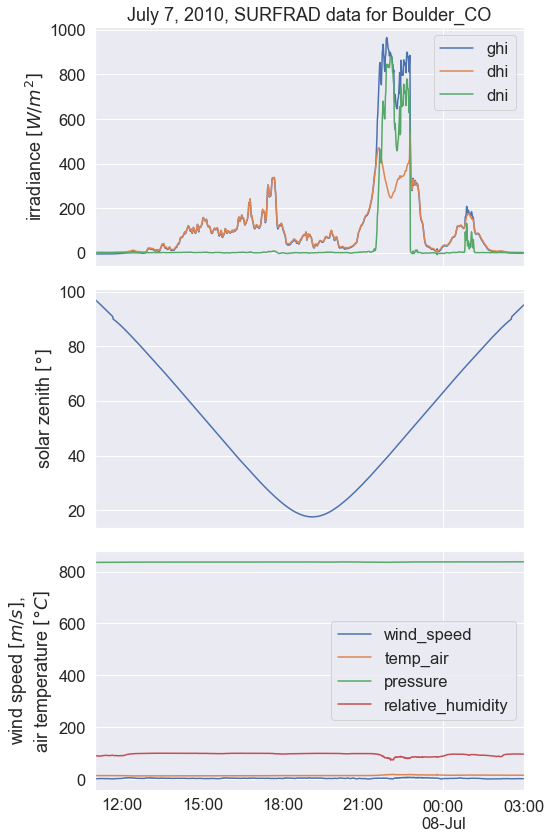

In [23]:
f, ax = plt.subplots(3, 1, sharex=True, figsize=(8, 12))
df[JULY7_MORN:JULY7_NITE][REQD_COLS[:3]].plot(ax=ax[0])
ax[0].set_title(f'July 7, {YEAR}, SURFRAD data for {weather_dir}')
ax[0].set_ylabel('irradiance $[W/m^2]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[3]].plot(ax=ax[1])
ax[1].set_ylabel('solar zenith $[\degree]$')
df[JULY7_MORN:JULY7_NITE][REQD_COLS[4:]].plot(ax=ax[2])
ax[2].set_ylabel('wind speed $[m/s]$,\nair temperature $[\degree C]$')
f.tight_layout()

## Data quality
Do some basic quality checking:
1. no irradiance should be negative
2. the DHI has to be the same as
    $$GHI - DNI \cos \left( \theta \right)$$

Then plot a sample day and take a look:

In [24]:
dni = np.maximum(0, df['dni'])
ghi = np.maximum(0, df['ghi'])
dhi = np.maximum(0, df['dhi'])
zerad = np.radians(df['solar_zenith'])
dhi_calc = pd.Series(np.maximum(0, ghi - dni*np.cos(zerad)), name='DHI calc')
irr_check = pd.concat([dni, ghi, dhi, dhi_calc], axis=1)

In [25]:
# check the calculated zenith from SURFRAD
dhi_mbe = 100 * (
    sum(dhi.resample('D').sum() - dhi_calc.resample('D').sum())
    / sum(dhi.resample('D').sum()))
print(f'dhi MBE: {dhi_mbe}%')

dhi MBE: 6.672096989340264%


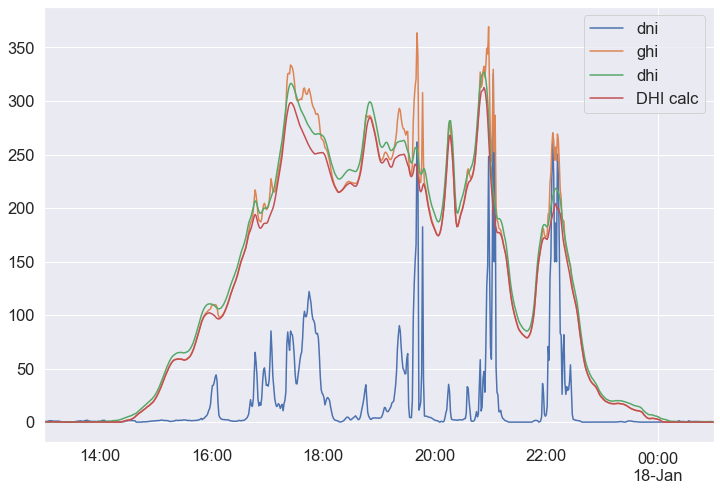

In [26]:
irr_check[JAN7_MORN:JAN7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

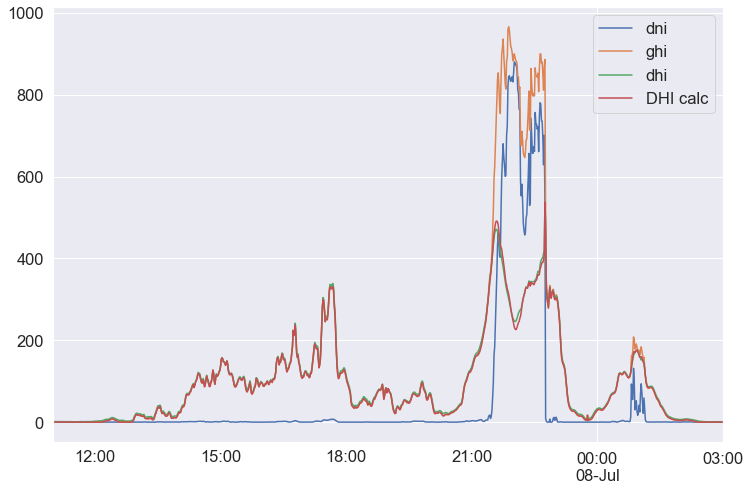

In [27]:
irr_check[JULY7_MORN:JULY7_NITE].plot()  # <-- XXX: pick dates for each month
plt.legend()

## assembling weather file
To model the output we need the following columns:
1. datetime as ISO8601 but no nanoseconds or timezone
2. GHI
2. DHI
3. Temp
4. WS

In [28]:
# get other parameters needed for modeling like windspeed and air temp
wspd = df['wind_speed']
tair = df['temp_air']

In [29]:
weather = pd.concat([ghi, dni, dhi, tair, wspd], axis=1)
weather.index.name = 'datetime'
weather.columns = ['GHI', 'DNI', 'DHI', 'Temp', 'WS']
weather.head()

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-01 00:00:00+00:00,0.0,3.4,2.7,1.0,3.2
2010-01-01 00:01:00+00:00,0.0,3.5,1.9,1.0,3.3
2010-01-01 00:02:00+00:00,0.0,3.1,1.6,1.1,3.6
2010-01-01 00:03:00+00:00,0.0,2.6,1.4,1.2,2.7
2010-01-01 00:04:00+00:00,0.0,2.8,1.2,1.2,4.2


In [30]:
weather.loc[f'{YEAR}-01-01T08:21:00{TZ}']  # <-- XXX: pick dates for each month

GHI     121.3
DNI     642.5
DHI      48.8
Temp     -3.5
WS        2.5
Name: 2010-01-01 15:21:00+00:00, dtype: float64

## Simulate 5-minute sampled satellite data
Choose instantaneous records every five minutes. Choose approximately the middle of the 5-minute sampling interval. Since these are 1-minute timestamps already, the closest to the middle is either the 2nd or 3rd minute.

In [31]:
weather5inst = weather.resample('5T').first()
weather5inst60min = weather5inst.resample('H').mean()
weather5inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-17 13:00:00+00:00,0.000000,0.725000,0.233333,8.808333,2.683333
2010-01-17 14:00:00+00:00,4.425000,0.566667,6.666667,7.516667,2.050000
2010-01-17 15:00:00+00:00,60.841667,1.966667,66.408333,8.666667,1.866667
2010-01-17 16:00:00+00:00,144.741667,14.291667,150.441667,9.816667,1.266667
2010-01-17 17:00:00+00:00,277.700000,62.025000,267.866667,9.841667,1.550000
2010-01-17 18:00:00+00:00,243.208333,9.275000,252.450000,9.583333,1.241667
2010-01-17 19:00:00+00:00,251.641667,35.691667,249.041667,9.650000,1.766667
2010-01-17 20:00:00+00:00,235.658333,13.858333,242.433333,10.300000,1.783333
2010-01-17 21:00:00+00:00,147.400000,28.550000,146.233333,10.950000,2.241667


## Ditto for every 15-minutes
Repeat for 15 minute intervals. Same dilemma, the closest record to the middle of the interval is either the 7th or 8th minute.

In [32]:
weather15inst = weather.resample('15T').first()
weather15inst60min = weather15inst.resample('H').mean()
weather15inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-17 13:00:00+00:00,0.000,0.775,0.200,8.825,2.550
2010-01-17 14:00:00+00:00,2.975,0.475,4.975,7.625,2.150
2010-01-17 15:00:00+00:00,53.450,1.500,58.850,8.400,1.775
2010-01-17 16:00:00+00:00,138.775,13.225,144.400,9.750,1.375
2010-01-17 17:00:00+00:00,267.325,54.125,260.600,9.800,1.625
2010-01-17 18:00:00+00:00,245.275,14.750,251.950,9.650,1.325
2010-01-17 19:00:00+00:00,249.000,25.075,251.575,9.650,1.925
2010-01-17 20:00:00+00:00,230.600,12.300,237.550,10.150,1.525
2010-01-17 21:00:00+00:00,150.675,18.100,153.800,11.100,1.900


## Ditto 30-minutes

In [33]:
weather30inst = weather.resample('30T').first()
weather30inst60min = weather30inst.resample('H').mean()
weather30inst60min[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-17 13:00:00+00:00,0.00,0.30,0.15,8.75,2.35
2010-01-17 14:00:00+00:00,0.90,0.95,2.80,8.50,2.10
2010-01-17 15:00:00+00:00,40.40,1.70,45.50,8.50,1.35
2010-01-17 16:00:00+00:00,126.45,14.45,131.45,9.50,1.45
2010-01-17 17:00:00+00:00,254.45,39.80,254.25,9.75,1.70
2010-01-17 18:00:00+00:00,243.60,13.90,251.35,9.90,1.25
2010-01-17 19:00:00+00:00,261.20,31.60,259.90,9.50,1.75
2010-01-17 20:00:00+00:00,190.45,2.05,202.60,10.10,1.20
2010-01-17 21:00:00+00:00,174.70,35.10,171.95,10.95,1.95


## Ditto 60-minutes

In [34]:
weather60inst = weather.resample('H').first()
weather60inst[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-17 13:00:00+00:00,0.0,0.4,0.1,8.1,2.4
2010-01-17 14:00:00+00:00,0.0,0.6,0.7,9.3,3.0
2010-01-17 15:00:00+00:00,22.4,1.3,26.3,7.6,1.4
2010-01-17 16:00:00+00:00,108.2,27.3,110.3,9.5,1.9
2010-01-17 17:00:00+00:00,199.4,35.1,200.3,10.0,2.2
2010-01-17 18:00:00+00:00,263.2,25.6,267.2,10.1,1.7
2010-01-17 19:00:00+00:00,250.8,3.9,263.9,9.9,0.9
2010-01-17 20:00:00+00:00,180.7,1.9,194.0,9.8,1.1
2010-01-17 21:00:00+00:00,261.7,70.2,248.4,10.9,1.9


# Visual Comparison of different sampling intervals
How do these look compared to each other? Are they shifted correctly? Are they on the same order? Do they capture the variability?

Text(0, 0.5, 'GHI $[W/m^2]$')

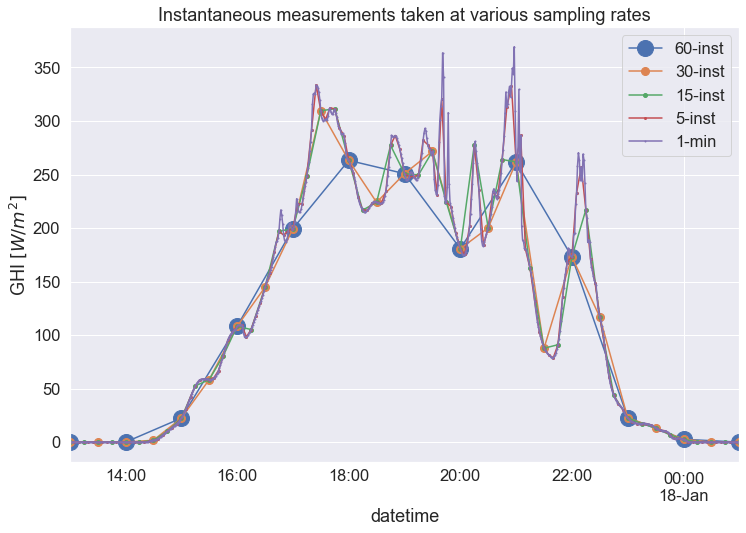

In [35]:
ax = weather60inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

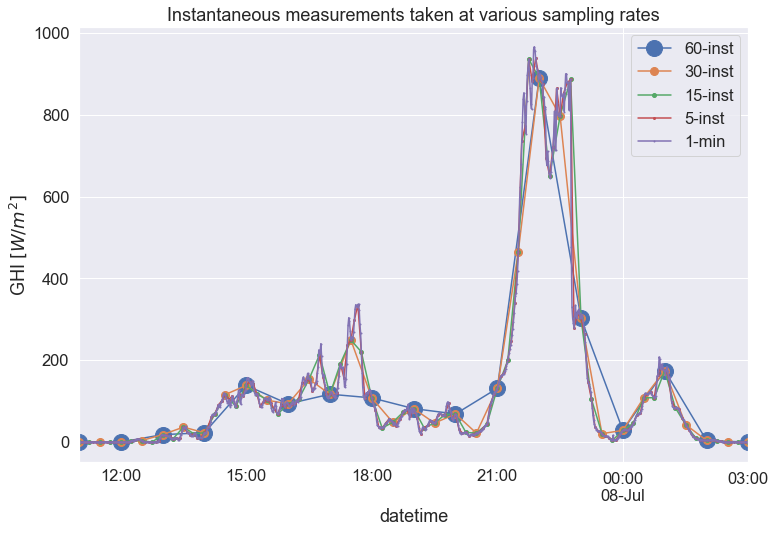

In [36]:
ax = weather60inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o', ms=16)
weather30inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=8)
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=4)
weather5inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=2)
weather[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o', ms=1)
plt.legend(['60-inst', '30-inst', '15-inst', '5-inst', '1-min'])
plt.title('Instantaneous measurements taken at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

## Hourly averages from instantaneously sampled

Text(0, 0.5, 'GHI $[W/m^2]$')

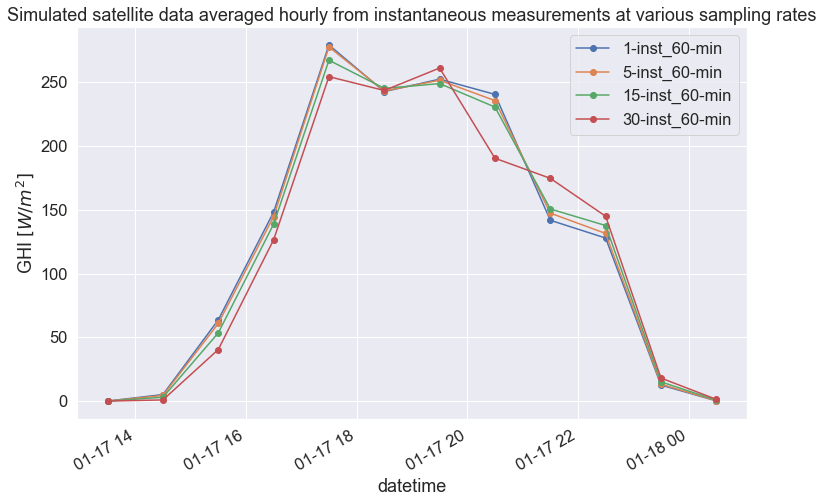

In [37]:
ax = weather.resample('H').mean().shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

Text(0, 0.5, 'GHI $[W/m^2]$')

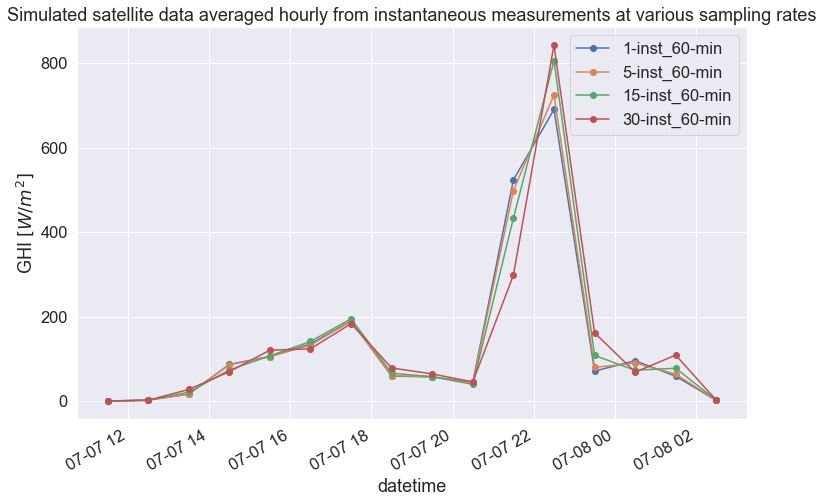

In [38]:
ax = weather.resample('H').mean().shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather5inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather15inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
weather30inst60min.shift(freq='30min')[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_60-min', '5-inst_60-min', '15-inst_60-min', '30-inst_60-min'])
plt.title('Simulated satellite data averaged hourly from instantaneous measurements at various sampling rates')
plt.ylabel('GHI $[W/m^2]$')

In [39]:
weather.resample('H').mean()[JAN7_MORN:JAN7_NITE]

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-01-17 13:00:00+00:00,0.000000,0.728333,0.246667,8.828333,2.713333
2010-01-17 14:00:00+00:00,5.105000,0.601667,7.488333,7.498333,2.055000
2010-01-17 15:00:00+00:00,63.666667,2.558333,69.288333,8.718333,1.908333
2010-01-17 16:00:00+00:00,148.215000,15.923333,153.393333,9.841667,1.250000
2010-01-17 17:00:00+00:00,279.276667,60.193333,270.136667,9.843333,1.573333
2010-01-17 18:00:00+00:00,242.716667,8.060000,252.538333,9.561667,1.243333
2010-01-17 19:00:00+00:00,252.478333,41.801667,246.755000,9.646667,1.706667
2010-01-17 20:00:00+00:00,240.531667,21.200000,244.505000,10.328333,1.831667
2010-01-17 21:00:00+00:00,141.803333,21.083333,143.455000,10.931667,2.211667


## Compare 15-minute time averaged to 15-minute instantaneous
How do shorter sampling intervals compare to time averaged values? Starting with 1-minute data, average every 15-minutes and compare to picking a single instantaneous record every 15 minutes, starting at the 7th minute.

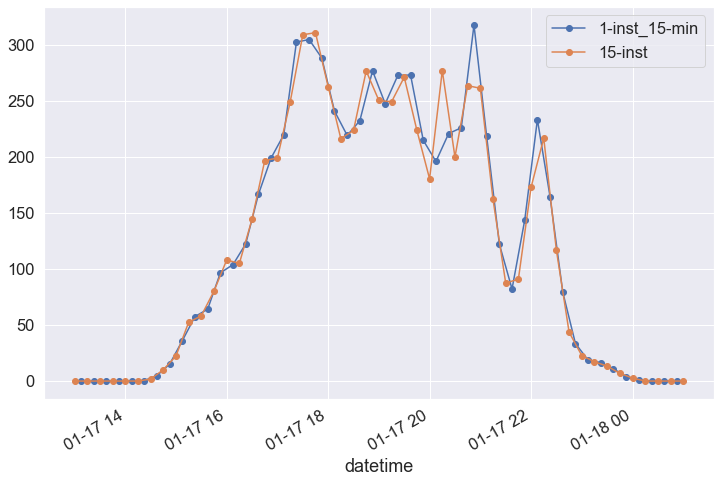

In [40]:
ax = weather.resample('15T').mean().shift(freq='450s')[JAN7_MORN:JAN7_NITE]['GHI'].plot(marker='o')
weather15inst[JAN7_MORN:JAN7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

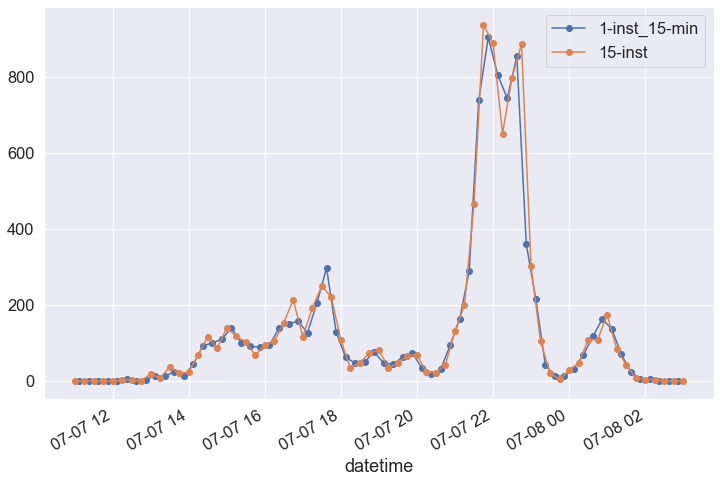

In [41]:
ax = weather.resample('15T').mean().shift(freq='450s')[JULY7_MORN:JULY7_NITE]['GHI'].plot(marker='o')
weather15inst[JULY7_MORN:JULY7_NITE]['GHI'].plot(ax=ax, marker='o')
plt.legend(['1-inst_15-min', '15-inst'])

In [42]:
weather.resample('15T').mean()[f'{YEAR}-07-07T11:00:00{TZ}':f'{YEAR}-07-07T13:00:00{TZ}']

,GHI,DNI,DHI,Temp,WS
datetime,,,,,
2010-07-07 18:00:00+00:00,62.060000,0.000000,67.220000,13.293333,3.573333
2010-07-07 18:15:00+00:00,47.393333,0.053333,52.173333,13.160000,2.960000
2010-07-07 18:30:00+00:00,50.300000,0.113333,54.313333,13.153333,3.846667
2010-07-07 18:45:00+00:00,76.533333,0.000000,77.560000,13.106667,4.046667
2010-07-07 19:00:00+00:00,47.666667,0.000000,49.820000,13.026667,3.900000
2010-07-07 19:15:00+00:00,44.140000,0.360000,46.013333,12.980000,3.833333
2010-07-07 19:30:00+00:00,62.806667,1.660000,65.106667,13.033333,2.300000
2010-07-07 19:45:00+00:00,74.813333,1.240000,78.073333,13.206667,2.273333
2010-07-07 20:00:00+00:00,34.920000,0.140000,39.053333,13.360000,3.100000


# Time Averaged
This is the original clipping error problem.

In [43]:
# timestamps are at the beginning of the interval
weather5min = weather.resample('5T').mean()
weather15min = weather.resample('15T').mean()
weather30min = weather.resample('30T').mean()
weather60min = weather.resample('H').mean()

# Run Model
Now we _finally_ have all the files for 2010 that we need, we can finally run the model and calculate the clipping errors. We'll come back and run it for other years and other sites once we get it working.

In [44]:
# use 250kWac typical central inverter
INVERTERS = pvlib.pvsystem.retrieve_sam('CECInverter')
INVERTER_250K = INVERTERS['SMA_America__SC250U__480V_']
INVERTER_250K

Vac                          480
Pso                  2064.528564
Paco                    250000.0
Pdco               259022.859375
Vdco                       370.0
C0                          -0.0
C1                      0.000005
C2                      0.001166
C3                     -0.000893
Pnt                         75.0
Vdcmax                     480.0
Idcmax                700.061782
Mppt_low                   330.0
Mppt_high                  480.0
CEC_Date               4/16/2018
CEC_Type     Utility Interactive
Name: SMA_America__SC250U__480V_, dtype: object

In [45]:
# choose typical front-contact silicon modules
CECMODS = pvlib.pvsystem.retrieve_sam('CECMod')
# for now, for simplicity, just one mono-silicon module, mono
CECMOD_MONO = CECMODS['Canadian_Solar_Inc__CS6X_300M']
CECMOD_MONO

Technology            Mono-c-Si
Bifacial                      0
STC                      300.03
PTC                       273.6
A_c                       1.852
Length                    1.931
Width                     0.959
N_s                          72
I_sc_ref                   8.74
V_oc_ref                   45.0
I_mp_ref                   8.22
V_mp_ref                   36.5
alpha_sc               0.004326
beta_oc                -0.15372
T_NOCT                     44.3
a_ref                  1.861184
I_L_ref                8.745869
I_o_ref                     0.0
R_s                    0.366101
R_sh_ref             545.178589
Adjust                 4.722239
gamma_r                  -0.442
BIPV                          N
Version       SAM 2018.11.11 r2
Date                   1/3/2019
Name: Canadian_Solar_Inc__CS6X_300M, dtype: object

In [46]:
# tracker positions
tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
surface_tilt = tracker['surface_tilt']
surface_azimuth = tracker['surface_azimuth']

In [47]:
# calculate irradiance inputs
dni_extra = pvlib.irradiance.get_extra_radiation(TIMES).values

In [48]:
# irrad components in plane of array
poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
aoi = tracker['aoi']
poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
poa_direct = poa['poa_direct']
poa_diffuse = poa['poa_diffuse']
poa_global = poa['poa_global']
iam = pvlib.iam.ashrae(aoi)
effective_irradiance = poa_direct*iam + poa_diffuse

In [49]:
# cell temperature with 10-minute rolling average
module_efficiency = CECMOD_MONO.STC / (CECMOD_MONO.A_c*1000)
temp_cell = pvlib.temperature.pvsyst_cell(
    poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
    module_efficiency=module_efficiency).rolling('10T', center=True).mean()

<AxesSubplot:>

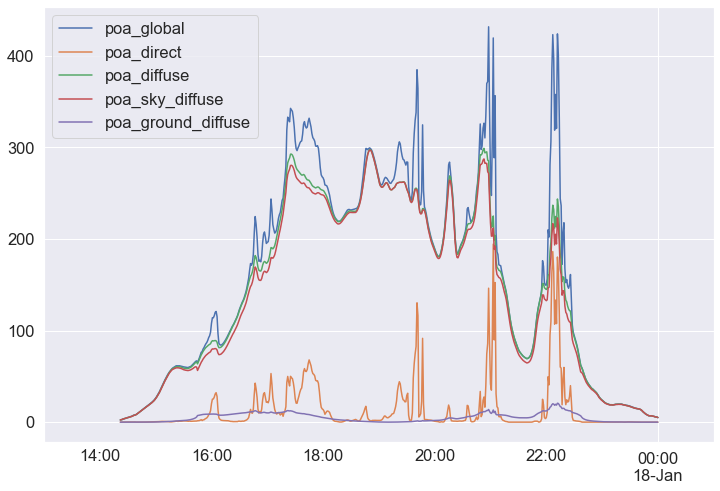

In [50]:
# the goods
poa[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

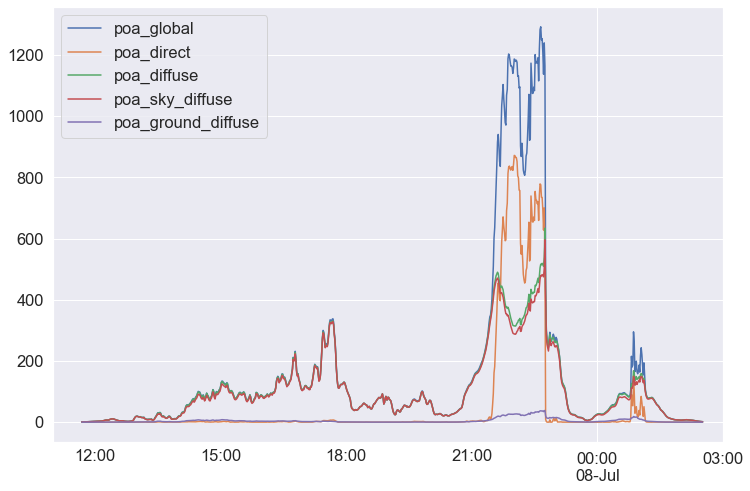

In [51]:
poa[JULY7_MORN:JULY7_NITE].plot()

In [52]:
# this is the magic
cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        CECMOD_MONO.alpha_sc, CECMOD_MONO.a_ref,
        CECMOD_MONO.I_L_ref, CECMOD_MONO.I_o_ref,
        CECMOD_MONO.R_sh_ref, CECMOD_MONO.R_s, CECMOD_MONO.Adjust)
mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
mpp = pd.DataFrame(mpp, index=TIMES)

In [53]:
module_efficiency

0.16200323974082073

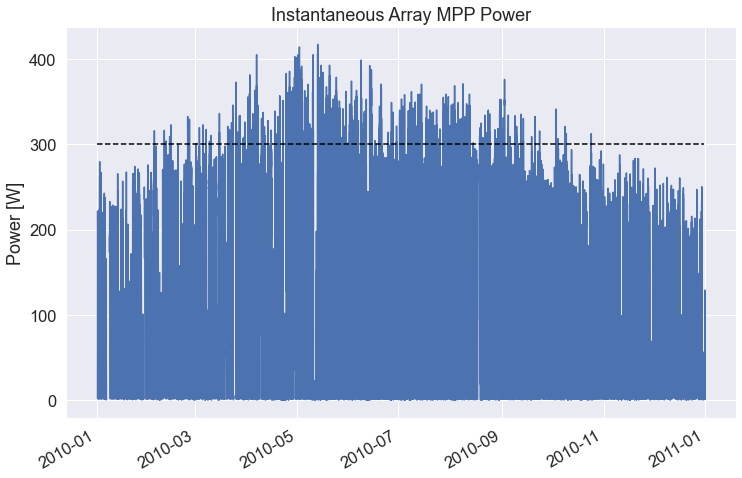

In [54]:
# the goods
mpp.p_mp.plot(title='Instantaneous Array MPP Power')
plt.hlines(xmin=f'{YEAR}-01-01', xmax=f'{YEAR}-12-31', y=CECMOD_MONO.STC, linestyles='--', colors='black')
plt.ylabel('Power [W]');

In [55]:
temp_ref = 25.0  # degC
dc_ac = 1.3
# maximum open circuit voltage
MAX_VOC = CECMOD_MONO.V_oc_ref + CECMOD_MONO.beta_oc * (tair.min() - temp_ref)
STRING_LENGTH = int(INVERTER_250K['Vdcmax'] // MAX_VOC)
STRING_VOLTAGE = STRING_LENGTH * MAX_VOC
STRING_OUTPUT = CECMOD_MONO.STC * STRING_LENGTH
STRING_COUNT = int(dc_ac * INVERTER_250K['Paco'] // STRING_OUTPUT)
DC_CAPACITY = STRING_COUNT * STRING_OUTPUT
DCAC = DC_CAPACITY / INVERTER_250K['Paco']
STRINGING_STATS = {
    'max Voc': MAX_VOC, 'string length': STRING_LENGTH, 'string voltage': STRING_VOLTAGE,
    'string output': STRING_OUTPUT, 'string count': STRING_COUNT, 'DC capacity': DC_CAPACITY,
    'DC/AC': DCAC}
STRINGING_STATS

{'max Voc': 51.502356,
 'string length': 9,
 'string voltage': 463.521204,
 'string output': 2700.2699999999995,
 'string count': 120,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

In [56]:
DC_OUTPUT = mpp.p_mp * STRING_LENGTH * STRING_COUNT
AC_OUTPUT = pvlib.inverter.sandia(
    mpp.v_mp * STRING_LENGTH,
    mpp.p_mp * STRING_LENGTH * STRING_COUNT,
    INVERTER_250K)
AC_OUTPUT.max()

250000.0

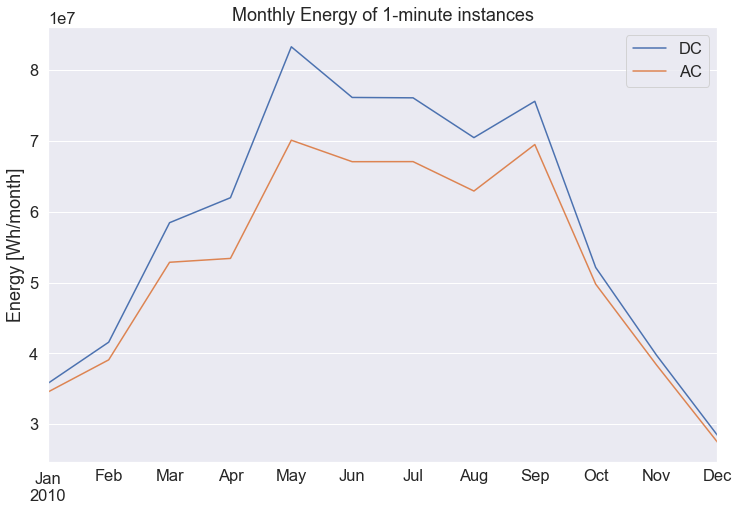

In [57]:
# the goods
EARRMPP = 1/60*DC_OUTPUT
EGRID = 1/60*AC_OUTPUT
ax = EARRMPP.resample('M').sum().plot(label='DC', title='Monthly Energy of 1-minute instances')
EGRID.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [58]:
print(f'1-minute instant annual DC & AC energy: {EARRMPP.sum()/1e6, EGRID.sum()/1e6} MWh')

1-minute instant annual DC & AC energy: (699.6983261727902, 632.2032137899308) MWh


<AxesSubplot:>

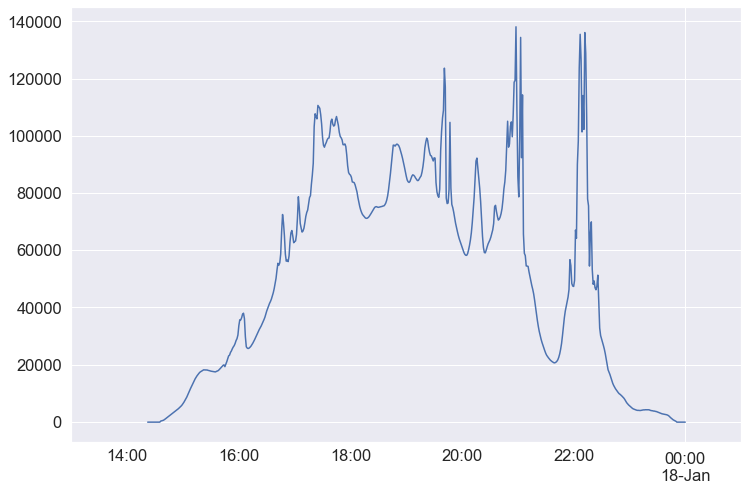

In [59]:
AC_OUTPUT[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

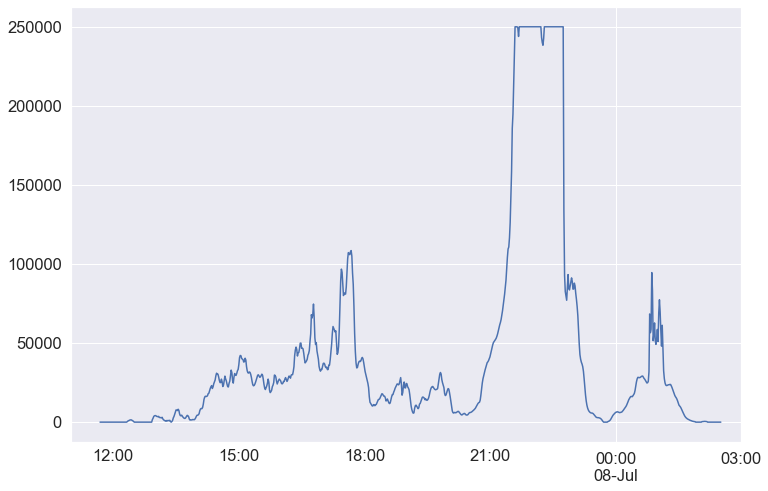

In [60]:
AC_OUTPUT[JULY7_MORN:JULY7_NITE].plot()

<AxesSubplot:>

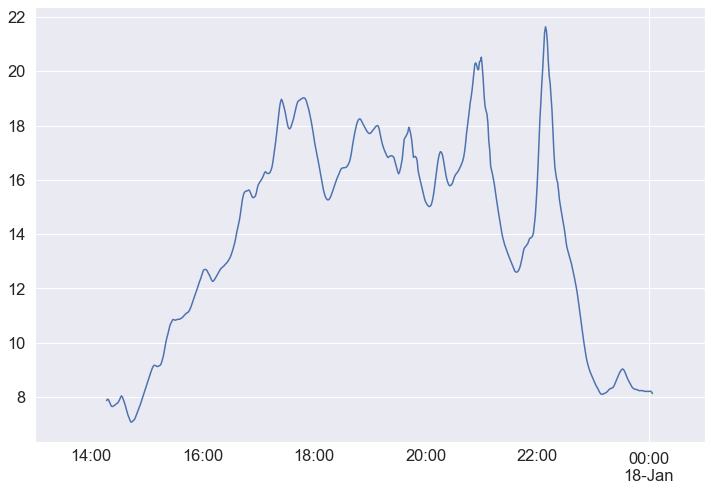

In [61]:
temp_cell[JAN7_MORN:JAN7_NITE].plot()

<AxesSubplot:>

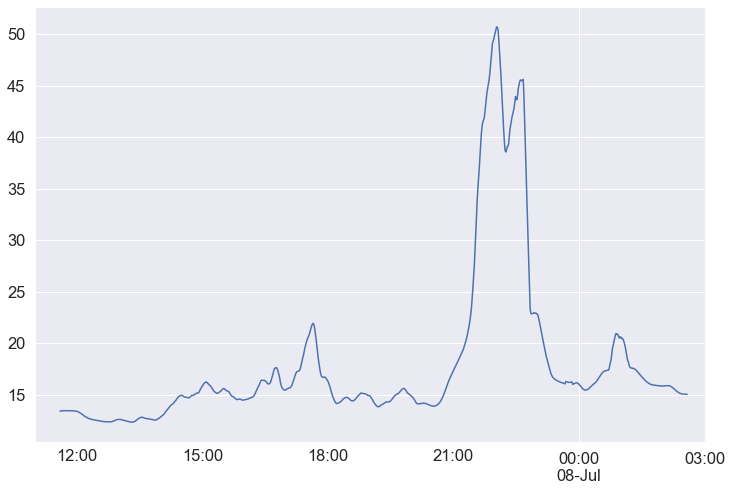

In [62]:
temp_cell[JULY7_MORN:JULY7_NITE].plot()

## More Convenient Functions
Create a function to automate the tasks above for all of datasets in the analysis.

### PV Model
This is a data class that just has the PV module and inverter parameters

### `calc_power()`
This is a function that outputs the instantaneous DC and AC power at each instant. Multiply output by the timestep in hours to get the energy.

### weather files
Now we use the convenience functions to loop over all 15 types of weather files.

#### instantaneous measurements
1. `weather`: 1-minute instantaneous
2. `weather5inst`: every 5th minute
3. `weather15inst`: every 15th minute
4. `weather30inst`: every 30th minute
5. `weather60inst`: once an hour

#### simulated satellite
instantaneous time-averaged to hourly
1. `weather60min`: 1-minute instances time-averaged to hourly
2. `weather5inst60min`: 5-minute instances time-average to hourly
3. `weather15inst60min`: 15-minute instances time-averaged to hourly
4. `weather30inst60min`: 30-minute instances time-averaged to hourly
5. `weather60inst`: once an hour

#### time-averaged
1. `weather`: 1-minute instantaneous
2. `weather5min`: 5-minute time-averaged
3. `weather15min`: 15-minute time-averaged
4. `weather30min`: 30-minute time-averaged
5. `weather60min`: 60-minute time-averaged

In [63]:
# some more convenient functions

@dataclass
class PVModel:
    latitude: float
    longitude: float
    elevation: float
    pvmodule : dict
    inverter : dict
    temp_ref: float = 25.0  # degC
    dc_ac: float = 1.3

    def string_array(self, tair) -> dict:
        # maximum open circuit voltage
        max_voc = self.pvmodule.V_oc_ref + self.pvmodule.beta_oc * (tair.min() - self.temp_ref)
        string_length = int(self.inverter['Vdcmax'] // max_voc)
        string_voltage = string_length * max_voc
        string_output = self.pvmodule.STC * string_length
        string_count = int(dc_ac * self.inverter['Paco'] // string_output)
        dc_capacity = string_count * string_output
        dc_ac_actual = dc_capacity / self.inverter['Paco']
        string_stats = {
            'max Voc': max_voc, 'string length': string_length, 'string voltage': string_voltage,
            'string output': string_output, 'string count': string_count, 'DC capacity': dc_capacity,
            'DC/AC': dc_ac_actual}
        return string_stats


def calc_power(df, pvmodel):
    # unpack weather
    times = df.index
    dni = df['DNI']
    ghi = df['GHI']
    dhi = df['DHI']
    tair = df['Temp']
    wspd = df['WS']

    # unpack pvmodel
    latitude = pvmodel.latitude
    longitude = pvmodel.longitude
    pvmodule = pvmodel.pvmodule
    inverter = pvmodel.inverter
    temp_ref = pvmodel.temp_ref
    dc_ac = pvmodel.dc_ac

    # string array
    string_stats = pvmodel.string_array(tair)
    string_length = string_stats['string length']
    string_count = string_stats['string count']

    # get solar position
    center_time = times.freq
    if center_time is None:
        center_time = times
    else:
        center_time = times.shift(freq=center_time/2)
    sp = pvlib.solarposition.get_solarposition(
        center_time, latitude, longitude)
    solar_zenith = sp.apparent_zenith.values
    solar_azimuth = sp.azimuth.values

    # tracker positions
    tracker = pvlib.tracking.singleaxis(solar_zenith, solar_azimuth)
    surface_tilt = tracker['surface_tilt']
    surface_azimuth = tracker['surface_azimuth']

    # calculate irradiance inputs
    dni_extra = pvlib.irradiance.get_extra_radiation(times).values

    # irrad components in plane of array
    poa_sky_diffuse = pvlib.irradiance.get_sky_diffuse(
        surface_tilt, surface_azimuth, solar_zenith, solar_azimuth,
        dni, ghi, dhi, dni_extra=dni_extra, model='haydavies')
    aoi = tracker['aoi']
    poa_ground_diffuse = pvlib.irradiance.get_ground_diffuse(
        surface_tilt, ghi)
    poa = pvlib.irradiance.poa_components(
        aoi, dni, poa_sky_diffuse, poa_ground_diffuse)
    poa_direct = poa['poa_direct']
    poa_diffuse = poa['poa_diffuse']
    poa_global = poa['poa_global']
    iam = pvlib.iam.ashrae(aoi)
    effective_irradiance = poa_direct*iam + poa_diffuse

    # cell temperature with 10-minute rolling average
    module_efficiency = pvmodule.STC / (pvmodule.A_c*1000)
    temp_cell = pvlib.temperature.pvsyst_cell(
        poa_global, temp_air=tair, wind_speed=wspd, u_c=25.0, u_v=1.2,
        module_efficiency=module_efficiency).rolling('10T', center=True).mean()
    
    # this is the magic
    cecparams = pvlib.pvsystem.calcparams_cec(
        effective_irradiance, temp_cell,
        pvmodule.alpha_sc, pvmodule.a_ref,
        pvmodule.I_L_ref, pvmodule.I_o_ref,
        pvmodule.R_sh_ref, pvmodule.R_s, pvmodule.Adjust)
    mpp = pvlib.pvsystem.max_power_point(*cecparams, method='newton')
    mpp = pd.DataFrame(mpp, index=times)

    # the goods
    dc_output = mpp.p_mp * string_length * string_count
    ac_output = pvlib.inverter.sandia(
        mpp.v_mp * string_length,
        mpp.p_mp * string_length * string_count,
        inverter)
    return dc_output, ac_output, string_stats

## PV model for Bondville, IL
This `PVModel` has the coordinates for Bondville, IL

In [64]:
pvmodel_bon = PVModel(
    latitude=LATITUDE,
    longitude=LONGITUDE,
    elevation=ELEVATION,
    pvmodule=CECMOD_MONO,
    inverter=INVERTER_250K)

## 5-minute instances
test out the function on the 5-minute instances

In [65]:
dc_out_5inst, ac_out_5inst, string_stats = calc_power(df=weather5inst, pvmodel=pvmodel_bon)
string_stats

{'max Voc': 51.502356,
 'string length': 9,
 'string voltage': 463.521204,
 'string output': 2700.2699999999995,
 'string count': 120,
 'DC capacity': 324032.39999999997,
 'DC/AC': 1.2961295999999998}

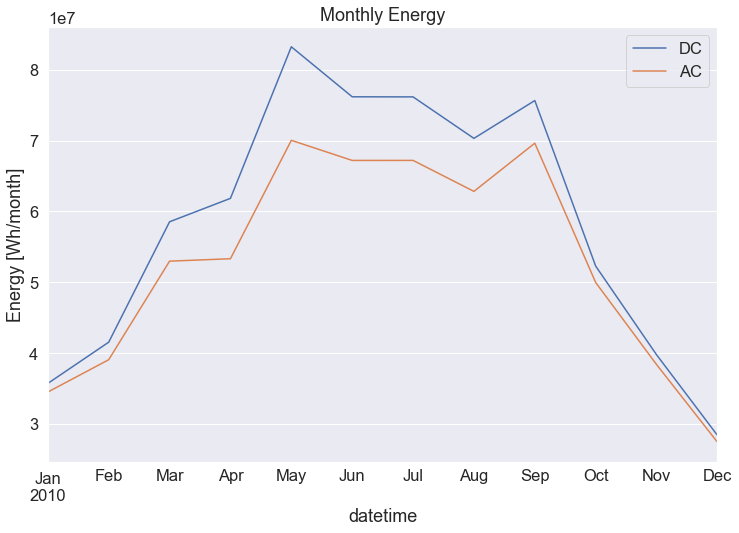

In [66]:
# the goods
earrmpp_5inst = 5/60*dc_out_5inst
egrid_5inst = 5/60*ac_out_5inst
ax = earrmpp_5inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_5inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [67]:
print(f'5-minute instant annual DC & AC energy: {earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6} MWh')

5-minute instant annual DC & AC energy: (699.7428804879631, 632.7541526951255) MWh


## 15-minute instances

In [68]:
dc_out_15inst, ac_out_15inst, _ = calc_power(df=weather15inst, pvmodel=pvmodel_bon)

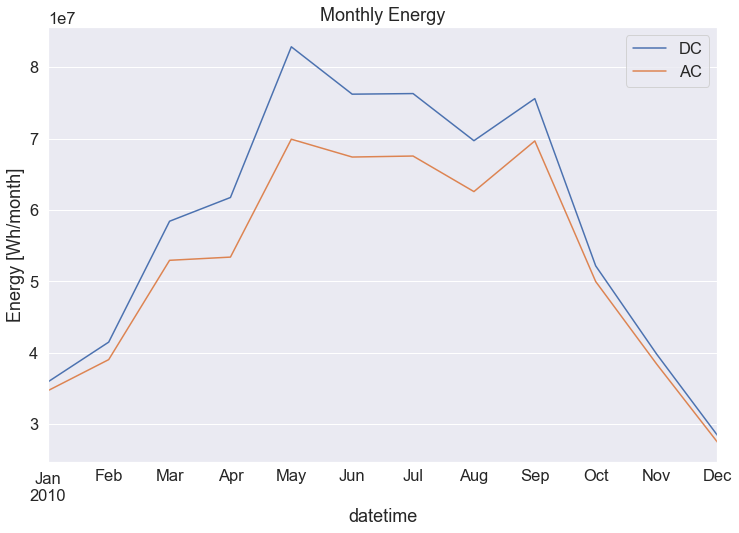

In [69]:
# the goods
earrmpp_15inst = 15/60*dc_out_15inst
egrid_15inst = 15/60*ac_out_15inst
ax = earrmpp_15inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_15inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [70]:
print(f'15-minute instant annual DC & AC energy: {earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6} MWh')

15-minute instant annual DC & AC energy: (698.645650874593, 633.0511098519386) MWh


## 30-minute instances

In [71]:
dc_out_30inst, ac_out_30inst, _ = calc_power(df=weather30inst, pvmodel=pvmodel_bon)

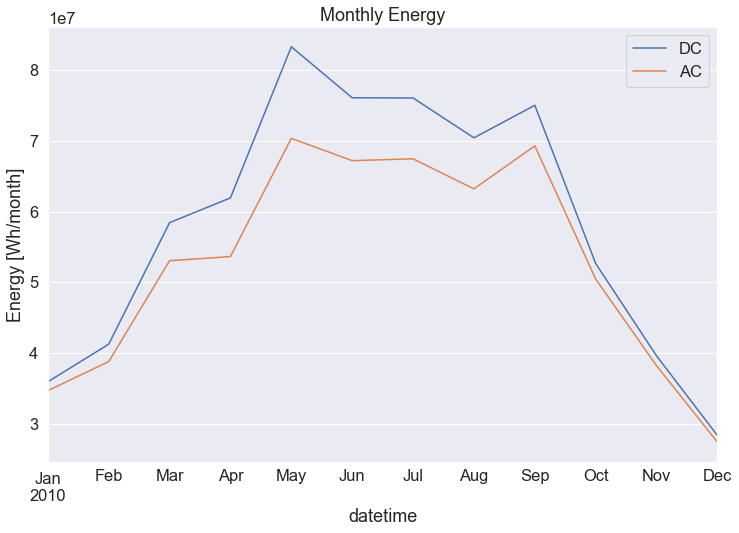

In [72]:
# the goods
earrmpp_30inst = 30/60*dc_out_30inst
egrid_30inst = 30/60*ac_out_30inst
ax = earrmpp_30inst.resample('M').sum().plot(label='DC', title='Monthly Energy')
egrid_30inst.resample('M').sum().plot(ax=ax, label='AC')
plt.ylabel('Energy [Wh/month]')
plt.legend()

In [73]:
print(f'30-minute instant annual DC & AC energy: {earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6} MWh')

30-minute instant annual DC & AC energy: (699.0616810117931, 633.7186828537987) MWh


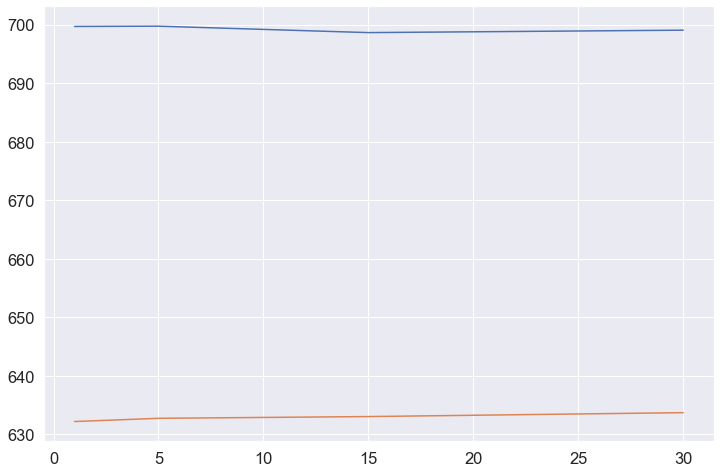

In [74]:
plt.plot(
    [1, 5, 15, 30],
    [(EARRMPP.sum()/1e6, EGRID.sum()/1e6),
     (earrmpp_5inst.sum()/1e6, egrid_5inst.sum()/1e6),
     (earrmpp_15inst.sum()/1e6, egrid_15inst.sum()/1e6),
     (earrmpp_30inst.sum()/1e6, egrid_30inst.sum()/1e6)])

## Automate
Run all the cases in a loop
1. instantaneous
2. satellite simulated
3. time-average

In [75]:
# loop over all instantaneous weather datasets
weather_inst = {
    1: weather, 5: weather5inst, 15: weather15inst, 30: weather30inst,
    60: weather60inst}
dc_out_inst = dict.fromkeys(weather_inst)
ac_out_inst = dict.fromkeys(weather_inst)
earrmpp_inst = dict.fromkeys(weather_inst)
egrid_inst = dict.fromkeys(weather_inst)
annual_energy_inst = dict.fromkeys(weather_inst)
for t, w in weather_inst.items():
    dc_out_inst[t], ac_out_inst[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_inst[t] = t/60*dc_out_inst[t]
    egrid_inst[t] = t/60*ac_out_inst[t]
    annual_energy_inst[t] = {
        'EArrMPP': earrmpp_inst[t].sum()/1e6, 'Egrid': egrid_inst[t].sum()/1e6}

,EArrMPP,Egrid
1,699.698326,632.203214
5,699.742880,632.754153
15,698.645651,633.051110
30,699.061681,633.718683
60,696.238402,631.347619


<AxesSubplot:>

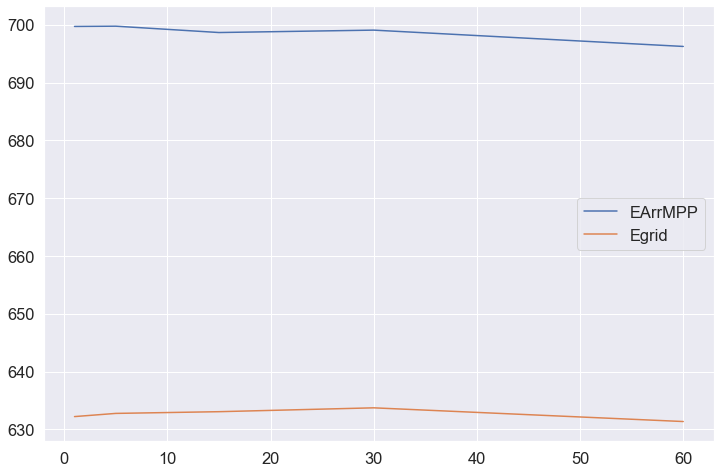

In [76]:
annual_energy_inst_df = pd.DataFrame(annual_energy_inst).T
display(annual_energy_inst_df)
annual_energy_inst_df.plot()

In [77]:
# loop over all instantaneous weather datasets time-averaged to hourly
weather_60min = {
    1: weather60min, 5: weather5inst60min, 15: weather15inst60min,
    30: weather30inst60min, 60: weather60inst}
dc_out_60min = dict.fromkeys(weather_60min)
ac_out_60min = dict.fromkeys(weather_60min)
earrmpp_60min = dict.fromkeys(weather_60min)
egrid_60min = dict.fromkeys(weather_60min)
annual_energy_60min = dict.fromkeys(weather_60min)
for t, w in weather_60min.items():
    dc_out_60min[t], ac_out_60min[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_60min[t] = dc_out_60min[t]
    egrid_60min[t] = ac_out_60min[t]
    annual_energy_60min[t] = {
        'EArrMPP': earrmpp_60min[t].sum()/1e6,
        'Egrid': egrid_60min[t].sum()/1e6}

,EArrMPP,Egrid
1,702.481545,648.400800
5,702.382649,648.369006
15,701.584488,646.632370
30,701.163219,643.190753
60,696.238402,631.347619


<AxesSubplot:>

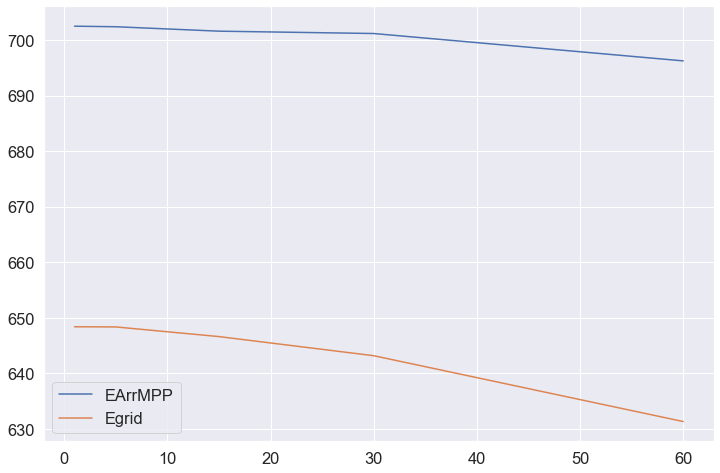

In [78]:
annual_energy_60min_df = pd.DataFrame(annual_energy_60min).T
display(annual_energy_60min_df)
annual_energy_60min_df.plot()

In [79]:
# loop over all time-averaged weather datasets
weather_avg = {
    1: weather, 5: weather5min, 15: weather15min, 30: weather30min,
    60: weather60min}
dc_out_avg = dict.fromkeys(weather_avg)
ac_out_avg = dict.fromkeys(weather_avg)
earrmpp_avg = dict.fromkeys(weather_avg)
egrid_avg = dict.fromkeys(weather_avg)
annual_energy_avg = dict.fromkeys(weather_avg)
for t, w in weather_avg.items():
    dc_out_avg[t], ac_out_avg[t], _ = calc_power(df=w, pvmodel=pvmodel_bon)
    earrmpp_avg[t] = t/60*dc_out_avg[t]
    egrid_avg[t] = t/60*ac_out_avg[t]
    annual_energy_avg[t] = {
        'EArrMPP': earrmpp_avg[t].sum()/1e6, 'Egrid': egrid_avg[t].sum()/1e6}

,EArrMPP,Egrid
1,699.698326,632.203214
5,700.353715,636.661140
15,701.223157,641.376777
30,702.079842,644.853946
60,702.481545,648.400800


<AxesSubplot:>

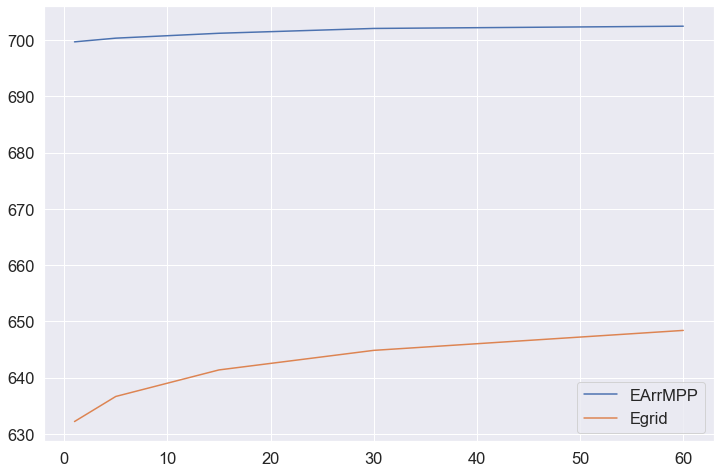

In [80]:
annual_energy_avg_df = pd.DataFrame(annual_energy_avg).T
display(annual_energy_avg_df)
annual_energy_avg_df.plot()

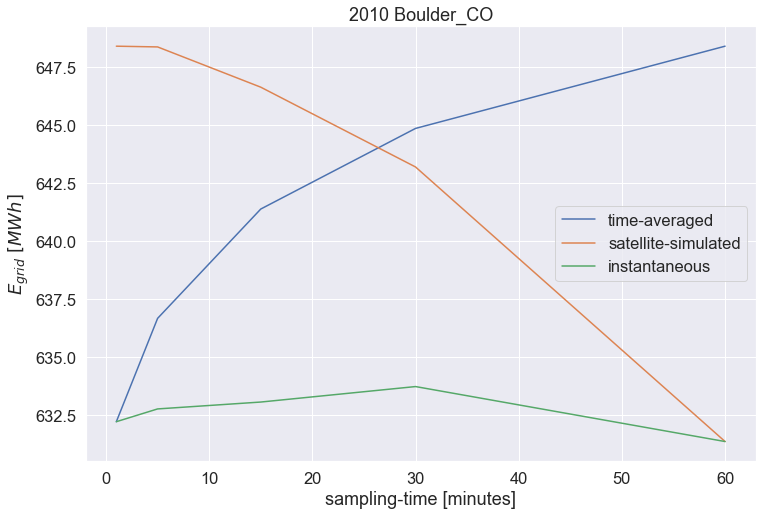

In [81]:
ax = annual_energy_avg_df['Egrid'].plot(label='time-averaged')
annual_energy_60min_df['Egrid'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['Egrid'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{grid}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()
plt.savefig(f'{CODENAME}{YEAR}.png');

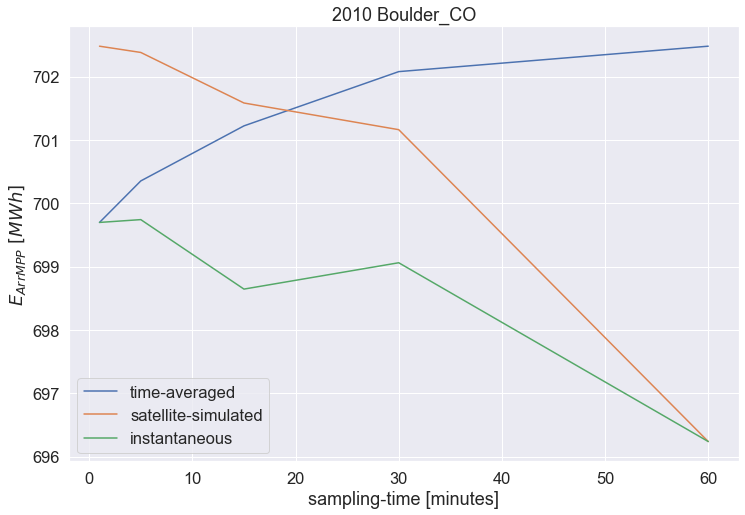

In [82]:
ax = annual_energy_avg_df['EArrMPP'].plot(label='time-averaged')
annual_energy_60min_df['EArrMPP'].plot(ax=ax, label='satellite-simulated')
annual_energy_inst_df['EArrMPP'].plot(ax=ax, label='instantaneous')
plt.xlabel('sampling-time [minutes]')
plt.ylabel('$E_{ArrMPP}\ [MWh]$')
plt.title(f'{YEAR} {weather_dir}')
plt.legend()

In [86]:
100*(annual_energy_avg_df['Egrid'][60]/annual_energy_avg_df['Egrid'][1] - 1)

2.5620854330824727

In [87]:
100*(annual_energy_60min_df['Egrid'][30]/annual_energy_avg_df['Egrid'][1] - 1)

1.7379758267062506